In [320]:
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
import warnings
from statistics import mean, median
warnings.filterwarnings('ignore')
import math

In [321]:
sample_size = 500
h = 0.05
window_width = 21  # must be 2k + 1 number

building distribution with trend $$\sqrt{k*h} + N(0,1)$$

In [322]:
norm_d = sc.stats.norm.rvs(0, 1, sample_size)
my_d = [math.sin(k*h) + (k*h) ** 0.5 + norm_d[k] for k in range(sample_size)]

Simple moving average method

In [323]:
def moving_avg(sample, window: int):
    """
    :param sample: moving_avg method will extract trend from sample
    :param window: window width
    :return: trend by moving_avg
    """
    gap = int((window - 1) / 2)
    output = [sample[0]]
    for i in range(1, gap):
        output.append(mean(sample[:2*i]))
    for i in range(gap, len(sample) - gap):
        output.append(mean(sample[i-gap:i+gap]))
    for i in range(len(sample) - gap, len(sample)):
        output.append(mean(sample[2*i - 2*len(sample):]))  # negative index

    return output


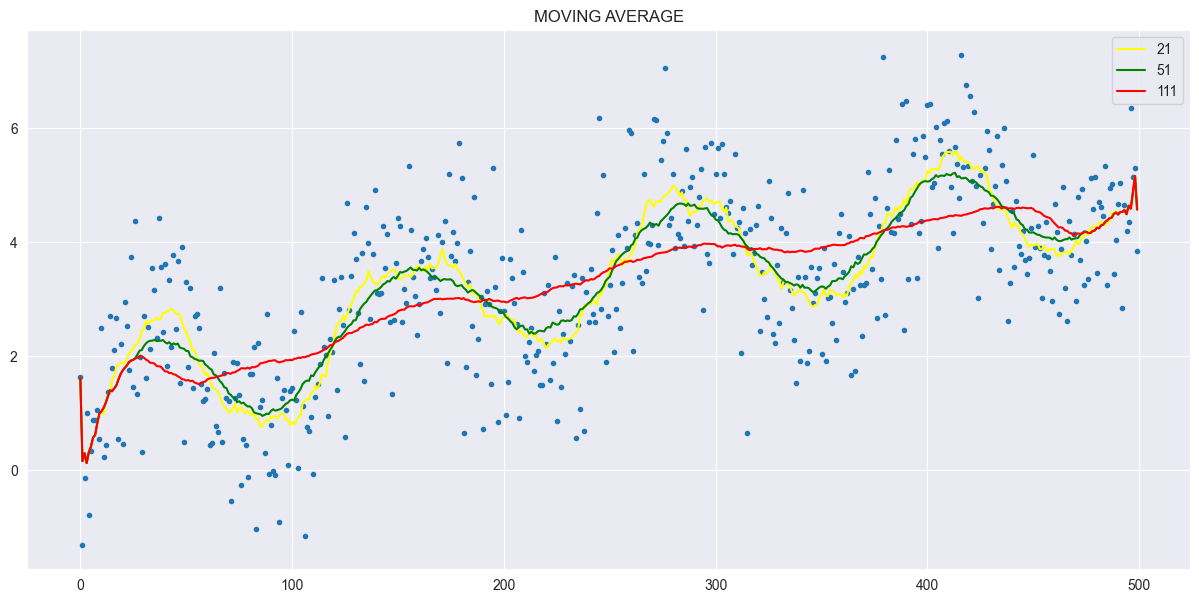

In [324]:
plt.plot(range(sample_size), my_d, '.')
plt.plot(range(sample_size), moving_avg(my_d, 21), 'yellow', label='21')
plt.plot(range(sample_size), moving_avg(my_d, 51), 'green', label='51')
plt.plot(range(sample_size), moving_avg(my_d, 111), 'red', label='111')
plt.title('MOVING AVERAGE')
plt.legend()


Weighted moving average method

In [325]:
def init_inv_N_matrix(polynom_extent, window: int):
    abscissa_values = range(-int((window - 1)/2), int((window - 1)/2) + 1)
    N = np.empty([polynom_extent + 1, polynom_extent + 1])
    for i in range(N.shape[0]):
        for j in range(i, N.shape[1]):
            N[i][j] = sum([item ** (i+j) for item in abscissa_values])
            N[j][i] = sum([item ** (i+j) for item in abscissa_values])

    return sc.linalg.inv(N)

def init_X_vector(x_slice, polynom_extent):
    abscissa_values = range(-int((len(x_slice) - 1)/2), int((len(x_slice) - 1)/2) + 1)
    X = np.array([0]*(polynom_extent + 1))
    for i in range(polynom_extent + 1):
        X[i] = sum([abscissa_values[k] ** i * x_slice[k] for k in range(len(abscissa_values))])  # ToDo range

    return X

def moving_avg_BOOST(sample, window, polynom_extent = 1):
    N_inv = init_inv_N_matrix(polynom_extent, window)

    gap = int((window - 1) / 2)
    output = [sample[0]]
    for i in range(1, gap):
        output.append(mean(sample[:2*i]))
    for i in range(gap, len(sample) - gap):
        X = init_X_vector(sample[i-gap:i+gap+1], polynom_extent)
        A = N_inv.dot(X)
        output.append(A[0])
    for i in range(len(sample) - gap, len(sample)):
        output.append(mean(sample[2*i - 2*len(sample):]))  # negative index

    return output

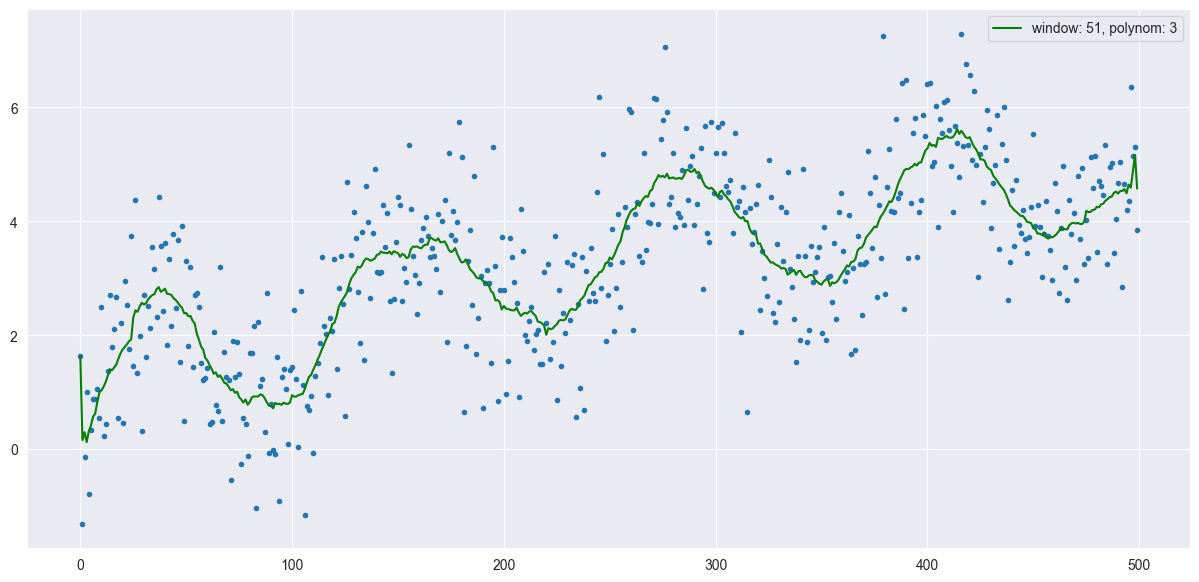

In [326]:
plt.plot(range(sample_size), my_d, '.')
plt.plot(range(sample_size), moving_avg_BOOST(my_d, 51, 3), 'green', label='window: 51, polynom: 3')
plt.legend()

Moving median method

In [327]:
def moving_med(sample, window: int):
    """
    :param sample: moving_med method will extract trend from sample
    :param window: window width
    :return: trend by moving_avg
    """
    gap = int((window - 1) / 2)
    output = [median([sample[0], sample[1], 3*sample[1] - 2*sample[2]])]
    for i in range(1, gap):
        output.append(median(sample[:2*i]))
    for i in range(gap, len(sample) - gap):
        output.append(median(sample[i-gap:i+gap]))
    for i in range(len(sample) - gap, len(sample)):
        output.append(median(sample[2*i - 2*len(sample):]))  # negative index

    output[-1] = median([sample[-1], sample[-2], 3*sample[-2] - 2*sample[-3]])
    return output

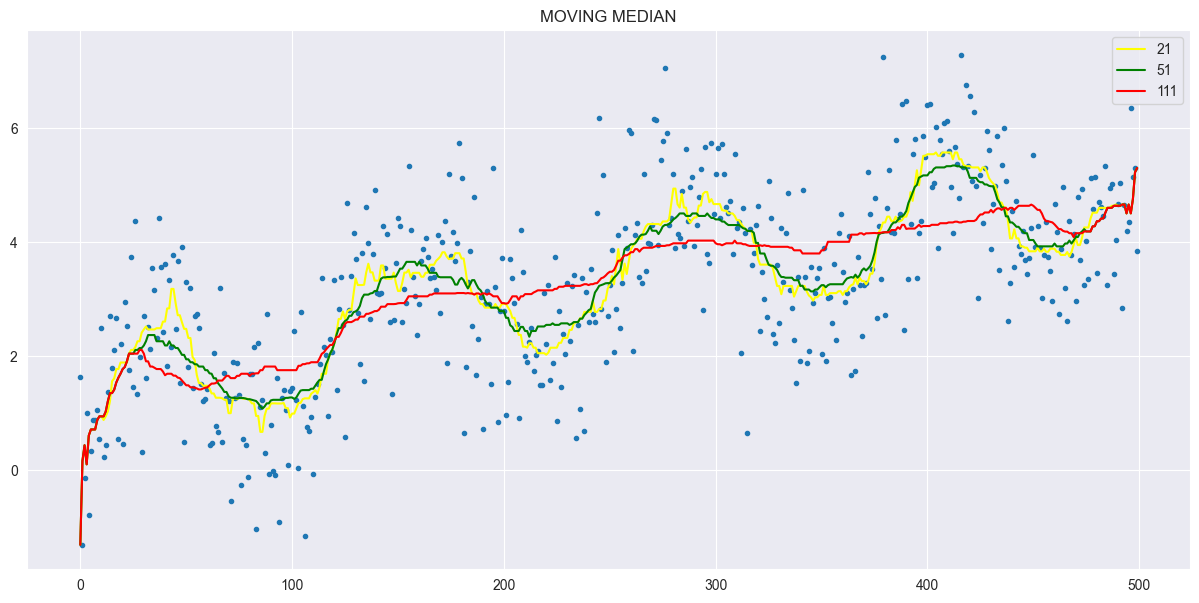

In [328]:
plt.plot(range(sample_size), my_d, '.')
plt.plot(range(sample_size), moving_med(my_d, 21), 'yellow', label='21')
plt.plot(range(sample_size), moving_med(my_d, 51), 'green', label='51')
plt.plot(range(sample_size), moving_med(my_d, 111), 'red', label='111')
plt.title('MOVING MEDIAN')
plt.legend()

Noise calculating, check on randomness

In [329]:
avg_21 = moving_avg(my_d, 21)
avg_boost_21_5 = moving_avg_BOOST(my_d, 21, 5)
med_21 = moving_med(my_d, 21)

noise_avg = np.array(my_d) - np.array(avg_21)
noise_avg_boost = np.array(my_d) - np.array(avg_boost_21_5)
noise_med = np.array(my_d) - np.array(med_21)

Turn points criteria

In [330]:
def turn_point(lst):
    dx = np.diff(lst, axis=0)
    return np.sum(dx[1:] * dx[:-1] < 0)

th_val = (2/3) * (sample_size - 2)

print('Turn points criteria')
print('Theoretical value: ', th_val)
print('Experiment value minus noise_avg: ', turn_point(noise_avg))
print('Experiment value minus noise_avg_boost: ', turn_point(noise_avg_boost))
print('Experiment value minus noise_med: ', turn_point(noise_med))

Turn points criteria
Theoretical value:  332.0
Experiment value minus noise_avg:  340
Experiment value minus noise_avg_boost:  342
Experiment value minus noise_med:  346


Kendall criteria

In [331]:
def Kendal(noise):
    count = 0
    n = len(noise)
    for i in range(len(noise)):
        for j in range(i):
            if noise[i] > noise[j]:
                count +=1
    return 4*count/(n*(n-1)) - 1

print('Kendall criteria')
print('Experiment value minus noise_avg: ', Kendal(noise_avg))
print('Experiment value minus noise_avg_boost: ', Kendal(noise_avg_boost))
print('Experiment value minus noise_med: ', Kendal(noise_med))

Kendall criteria
Experiment value minus noise_avg:  -0.0051302605210420404
Experiment value minus noise_avg_boost:  -0.0037515030060120136
Experiment value minus noise_med:  -0.015615230460921836
